## Similarity metric analysis

We want to answer two main questions:
1. How does Acoustic Token Distribution Similarity correlate with conventional measures?
2. Which measures have the strongest correlation with WER?

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import pandas as pd
import scipy
import seaborn as sns

import similarity

sns.set_theme()

### 1. ATDS correlation with alternative measures

First we will take a look at the strength of the relationship of ATDS with other measures of language similarity. Specifically:
- SpeechBrain embeddings on the same data.
- lang2vec embeddings

In [3]:
sim_df = similarity.create_sim_df()

100%|██████████| 15/15 [00:00<00:00, 650.90it/s]


['malay', 'gujarati', 'iban', 'setswana', 'urdu', 'punjabi', 'marathi', 'sepedi', 'odia', 'indonesian', 'tamil', 'hindi', 'malayalam', 'sesotho', 'bengali']


In [11]:
# Drop dupliate lang pairs that result from different permutations of ref_lang and comp_lang
df = sim_df.copy()
df['lang_pair'] = df.apply(lambda x: sorted([x.ref_lang, x.comp_lang]), axis=1)
df = df.drop_duplicates(subset=['lang_pair'])

In [15]:
# First we will sort the data by its correlation
records = []
for column in [col for col in df.columns if col.endswith('distance') or col.endswith('similarity')]:
    r = scipy.stats.pearsonr(x=df[column], y=df.atds)
    records.append((column, r[0], r[1]))
pd.DataFrame.from_records(records, columns=['column', 'r', 'p']).sort_values(by='r', ascending=False)

,column,r,p
0,speechbrain_similarity,0.862795,2.039328e-13
4,genetic_distance,0.586854,4.411207e-05
5,inventory_distance,0.314997,4.216845e-02
1,syntactic_distance,0.158312,3.166568e-01
2,geographic_distance,0.065942,6.782113e-01
6,featural_distance,0.006898,9.654159e-01
3,phonological_distance,-0.048745,7.591852e-01


The correlation is quite low for all metrics except speech brain:

<Axes: xlabel='speechbrain_similarity', ylabel='atds'>

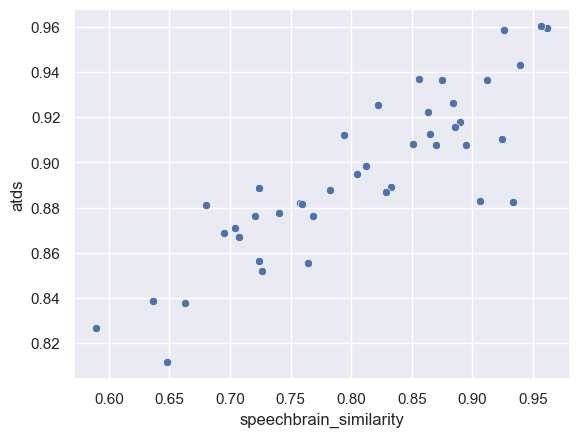

In [16]:
sns.scatterplot(data=df, x='speechbrain_similarity', y='atds')

The next best being:

<Axes: xlabel='genetic_distance', ylabel='atds'>

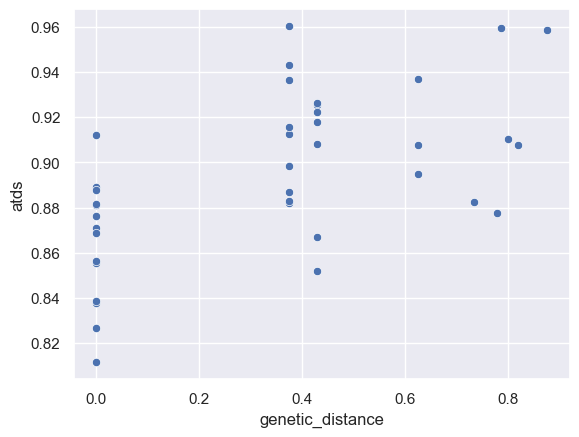

In [17]:
sns.scatterplot(data=df, x='genetic_distance', y='atds')

So the relationship between ATDS and metrics based on more conventional typographic measures is weak. That said, we will note that lang2vec does have some missing features. Also we should add in a comparison to the learned typographical features of Malaviya et al, 2017 here.

Note also that the 'distance' metrics above were converted to cosine similarity using 1 - dist_metric.

### 2. Correlation with WER of different metrics

Our primary interest is how well a given metric of language similarity predicts the value of continued pretraining of a model on a donor language before fine-tuning and deployment on a target language.

To this end we inspect how well the metrics correlate with WER in the ASR experiments we did.

In [26]:
wer_df = similarity.create_wer_and_sim_df()
wer_df['target_lang'] = wer_df['ref_lang']
wer_df['donor_lang'] = wer_df['comp_lang']

100%|██████████| 15/15 [00:00<00:00, 702.45it/s]


['malay', 'gujarati', 'iban', 'setswana', 'urdu', 'punjabi', 'marathi', 'sepedi', 'odia', 'indonesian', 'tamil', 'hindi', 'malayalam', 'sesotho', 'bengali']


First up let's just consier how ATDS relates to WER across three target languages:

<Axes: xlabel='atds', ylabel='wer'>

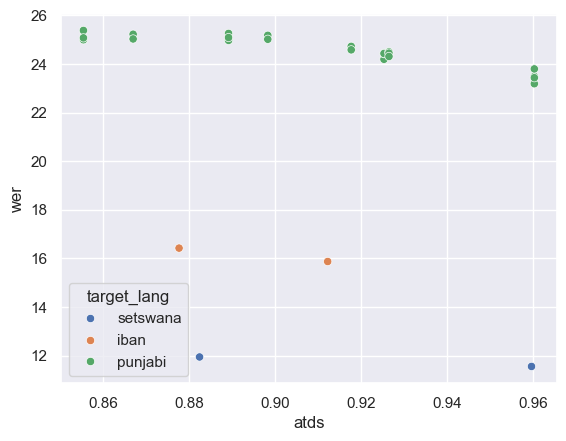

In [23]:
sns.scatterplot(data=wer_df, x='atds', y='wer', hue='target_lang')

Observe that:
- Each target language is on its own scale, so overall correlation adds noise here.
- Iban and Setswana have only two data points here, so technically speaking there is a perfect -1 correlation between the similarity metric and the WER.

Since Punjabi has a more substantial number of data points, we can consider just the subset of results where Punjabi was the target language.

Note that the clusters along the x axis correspond to donor languages. Where the similarity metric is the same, the clusters correspond to either different random seeds, or pre-training runs of different steps. So the statistical-p we get from correlation will be more confident than it should and inaccurate.

Not also that the WERs were somewhat YOLO-extracted from CSVs downloaded from wandb. Sometimes the numbers didn't seem to match up perfectly with what's in the google doc (I saw Punjabi-hindi seeds misalign with the reported numbers in Google doc), so I'm not 100% sure if what I've grabbed is correct and we probably want to double check these.

Here are the points where Punjabi is the target language, with the hue indicating the donor language:


<Axes: xlabel='atds', ylabel='wer'>

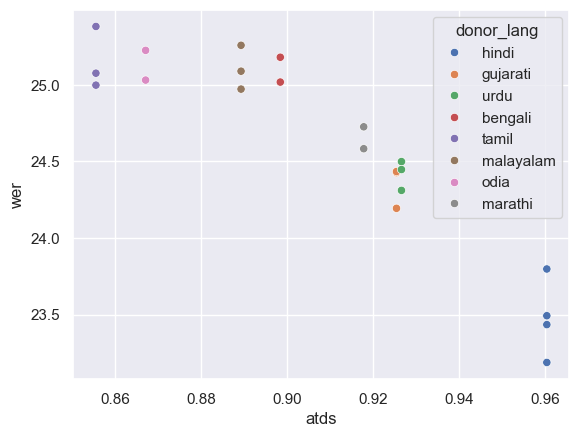

In [29]:
sns.scatterplot(data=wer_df[wer_df['ref_lang'] == 'punjabi'], x='atds', y='wer', hue='donor_lang')

That is a fairly compelling relationship! Looking at the donor-language clusters, ATDS has a fairly reliable negative relationship with WER

Now how does this relationship compare to what we got from other metrics?

In [34]:
df = wer_df[wer_df['ref_lang'] == 'punjabi']
records = []
for column in [col for col in df.columns if col.endswith('distance') or col.endswith('similarity') or col == 'atds']:
    r = scipy.stats.pearsonr(x=df[column], y=df.wer)
    records.append((column, r[0]))
pd.DataFrame.from_records(records, columns=['column', 'r']).sort_values(by='r', ascending=True)

,column,r
0,atds,-0.906513
2,syntactic_distance,-0.846381
1,speechbrain_similarity,-0.824913
3,geographic_distance,-0.801363
7,featural_distance,-0.798876
6,inventory_distance,-0.561647
5,genetic_distance,-0.492313
4,phonological_distance,0.540117


ATDS has the strongest negative correlation. The next best is syntactic difference, of all things. But the devil is in the details:

<Axes: xlabel='syntactic_distance', ylabel='wer'>

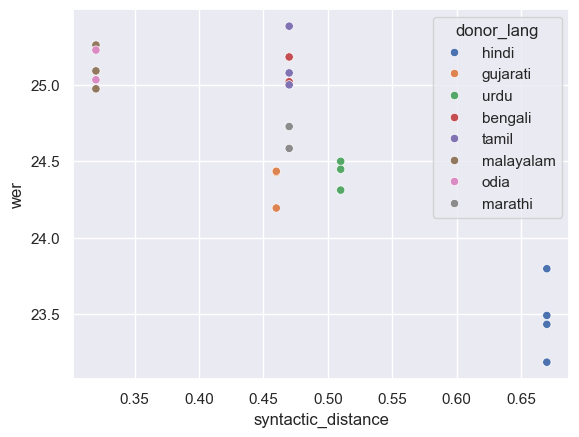

In [35]:
sns.scatterplot(data=wer_df[wer_df['ref_lang'] == 'punjabi'], x='syntactic_distance', y='wer', hue='donor_lang')

Syntactic difference is really clumped into 3 groups, and so the probability of it being an accident is quite high, though there might be some plausible underlying story, it's not going to be statistically significant.

Also with a high negative relationship were the Speechbrain embeddings:

<Axes: xlabel='speechbrain_similarity', ylabel='wer'>

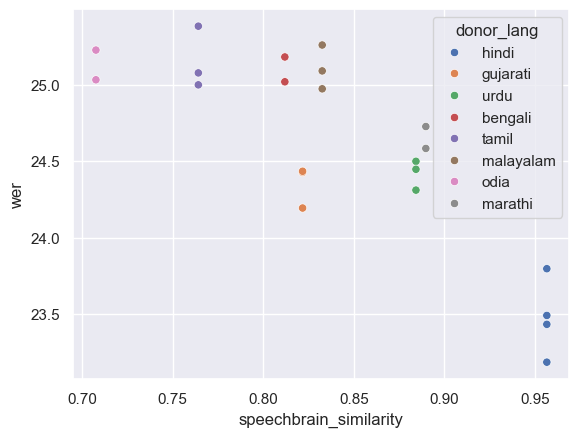

In [37]:
sns.scatterplot(data=wer_df[wer_df['ref_lang'] == 'punjabi'], x='speechbrain_similarity', y='wer', hue='donor_lang')

This is a lot more compelling than syntactic difference. But the relationship isn't quite as strong as ATDS. While it's impossible to know exactly why on the basis of this data alone, it's probably fair to say that using a metric specific to the features of the model you're finetuning is better than a metric based on features of another model, however good that model happens to be at the thing it does (in this case, language identification for the SpeechBrain classifier)

Note that it's possible that some more effective combination of lang2vec features could do a better job, I haven't tried that yet. Also still to try is the Malaviya approach.